In [1]:
import faceted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits
import numpy as np
import pandas as pd
import xarray as xr

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter

import plotting
import utils

In [2]:
plotting.configure_style()

In [3]:
VARIABLES = [
    "surface_temperature",
    "column_moist_static_energy",
    "net_energy_flux_into_atmospheric_column",
    "air_temperature_7",
    "air_temperature_4",
    "specific_total_water_4",
    "USWRFsfc",
    "ULWRFsfc",
    "DSWRFsfc",
    "DLWRFsfc",
    "LHTFLsfc",
    "SHTFLsfc"
]

In [4]:
REFERENCE = "SHiELD-SOM-C96"
BASELINE = "SHiELD-SOM-C24-tuned-cdmbgwd"
ACE2_SOM = "ACE2-SOM-multi-climate-RS3"
MODELS = [REFERENCE, BASELINE, ACE2_SOM]

In [5]:
def get_beaker_dataset_id(model):
    catalog = utils.open_catalog()
    case = catalog[(catalog["forcing"] == "abrupt-4xCO2") & (catalog["model"] == model) & catalog["tag"].isnull()]
    return case["beaker_id"].item()

def get_beaker_dataset_id_abbreviated(model):
    catalog = utils.open_catalog()
    case = catalog[(catalog["forcing"] == "abrupt-4xCO2") & (catalog["model"] == model) & (catalog["tag"] == "abbreviated")]
    return case["beaker_id"].item()

In [6]:
FULL_DATASET_IDS = {
    REFERENCE: get_beaker_dataset_id(REFERENCE),
    ACE2_SOM: get_beaker_dataset_id(ACE2_SOM),
    BASELINE: get_beaker_dataset_id(BASELINE)
}
NETCDF = "monthly_mean_predictions.nc"

ace2_som_full = utils.open_beaker_dataset(FULL_DATASET_IDS[ACE2_SOM], NETCDF, variables=VARIABLES)
reference_full = utils.open_beaker_dataset(FULL_DATASET_IDS[REFERENCE], NETCDF, variables=VARIABLES)
baseline_full = utils.open_beaker_dataset(FULL_DATASET_IDS[BASELINE], NETCDF, variables=VARIABLES).assign_coords(model=BASELINE)
ds_full = xr.concat([ace2_som_full, reference_full], dim=pd.Index([ACE2_SOM, REFERENCE], name="model"))

Output()

Output()

Output()

In [7]:
ABBREVIATED_DATASET_IDS = {
    REFERENCE: get_beaker_dataset_id_abbreviated(REFERENCE),
    ACE2_SOM: get_beaker_dataset_id_abbreviated(ACE2_SOM),
    BASELINE: get_beaker_dataset_id_abbreviated(BASELINE)
}
NETCDF = "autoregressive_predictions.nc"

ace2_som_abbreviated = utils.open_beaker_dataset(ABBREVIATED_DATASET_IDS[ACE2_SOM], NETCDF)
reference_abbreviated = utils.open_beaker_dataset(ABBREVIATED_DATASET_IDS[REFERENCE], NETCDF)
baseline_abbreviated = utils.open_beaker_dataset(ABBREVIATED_DATASET_IDS[BASELINE], NETCDF).assign_coords(model=BASELINE)
ds_abbreviated = xr.concat([ace2_som_abbreviated, reference_abbreviated], dim=pd.Index([ACE2_SOM, REFERENCE], name="model"))

Output()

Output()

Output()

In [8]:
four_degree_weights = utils.get_weights("gaussian_grid_45_by_90")
one_degree_weights = utils.get_weights("gaussian_grid_180_by_360")

In [9]:
regional_mean_full = ds_full.weighted(one_degree_weights).mean(["lat", "lon"]).isel(time=slice(None, -2)).squeeze()
baseline_regional_mean_full = baseline_full.weighted(four_degree_weights).mean(["lat", "lon"]).isel(time=slice(None, -2)).squeeze()
regional_mean_abbreviated = ds_abbreviated.weighted(one_degree_weights).mean(["lat", "lon"]).squeeze()
baseline_regional_mean_abbreviated = baseline_abbreviated.weighted(four_degree_weights).mean(["lat", "lon"]).squeeze()

regional_mean_full = xr.concat([regional_mean_full, baseline_regional_mean_full], dim="model")
regional_mean_abbreivated = xr.concat([regional_mean_abbreviated, baseline_regional_mean_abbreviated], dim="model")

(290.0, 296.0)

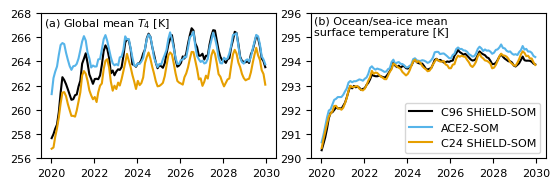

In [10]:
fig, (ax1, ax2) = faceted.faceted(
    1, 
    2, 
    aspect=0.618, 
    width=5.5, 
    internal_pad=0.35, 
    sharey=False,
    left_pad=0.35,
    right_pad=0.1,
    top_pad=0.1,
    bottom_pad=0.3
)

colors = {
    REFERENCE: "black",
    BASELINE: "C1",
    ACE2_SOM: "C0"
}
LABELS = {
    REFERENCE: "C96 SHiELD-SOM",
    BASELINE: "C24 SHiELD-SOM",
    ACE2_SOM: "ACE2-SOM"
}

for model in [REFERENCE, ACE2_SOM, BASELINE]:
    (
        regional_mean_full.air_temperature_4
        .sel(region="global", model=model)
        .plot(
            ax=ax1, 
            x="valid_time", 
            add_legend=False, 
            label=LABELS[model], 
            color=colors[model])
    )
    (
        regional_mean_full.surface_temperature
        .sel(region="non-land", model=model)
        .plot(
            ax=ax2, 
            x="valid_time", 
            add_legend=False, 
            label=LABELS[model], 
            color=colors[model])
    )

ax1.annotate(
    f"(a) Global mean $T_4$ [K]", 
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax2.annotate(
    f"(b) Ocean/sea-ice mean\nsurface temperature [K]", 
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)

ax2.legend(loc="lower right", fontsize=8)

for ax in (ax1, ax2):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_xticks(pd.date_range("2020", freq="2YS", periods=6))

ax1.set_ylim(256, 268)
ax2.set_ylim(290, 296)

In [11]:
TIMESTEP_SECONDS = 3600 * 6
tendency = regional_mean_abbreivated.column_moist_static_energy.sel(region="global").diff("time", label="lower") / TIMESTEP_SECONDS

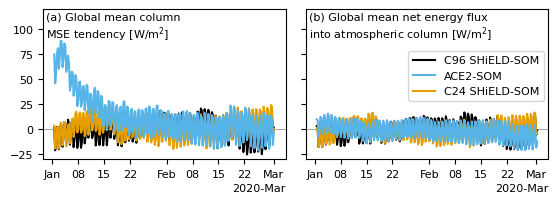

In [ ]:
fig, (ax1, ax2) = faceted.faceted(
    1, 
    2, 
    aspect=0.618, 
    width=5.5, 
    internal_pad=0.2, 
    sharey=True,
    left_pad=0.35,
    right_pad=0.1,
    top_pad=0.1,
    bottom_pad=0.5
)

colors = {
    REFERENCE: "black",
    BASELINE: "C1",
    ACE2_SOM: "C0"
}
LABELS = {
    REFERENCE: "C96 SHiELD-SOM",
    BASELINE: "C24 SHiELD-SOM",
    ACE2_SOM: "ACE2-SOM"
}
ZORDER = {
    REFERENCE: 0,
    BASELINE: 1,
    ACE2_SOM: 2,
}

for model in [REFERENCE, ACE2_SOM, BASELINE]:
    tendency.sel(model=model).plot(ax=ax1, x="valid_time", label=LABELS[model], color=colors[model], zorder=ZORDER[model])
    regional_mean_abbreivated.net_energy_flux_into_atmospheric_column.sel(region="global", model=model).plot(ax=ax2, x="valid_time", label=LABELS[model], color=colors[model], zorder=ZORDER[model])

ax1.annotate(
    f"(a) Global mean column\nMSE tendency [W/m$^2$]", 
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax2.annotate(
    f"(b) Global mean net energy flux\ninto atmospheric column [W/m$^2$]", 
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)

ax2.legend(loc="lower left", fontsize=8, bbox_to_anchor=(0.4, 0.35), bbox_transform=ax2.transAxes)

for ax in (ax1, ax2):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_ylim(-30, 120)
    ax.axhline(0.0, color="gray", zorder=0, lw=0.5)

fig.savefig(f"figures/figure-09.png", dpi=200)
fig.savefig(f"figures/figure-09.pdf")

In [13]:
bias = regional_mean_full.sel(model=ACE2_SOM) - regional_mean_full.sel(model=REFERENCE)

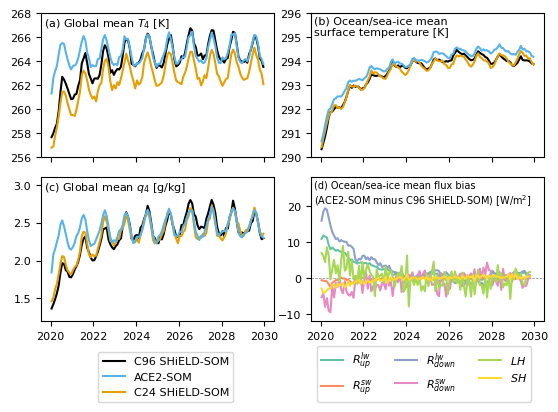

In [ ]:
fig, (ax1, ax2, ax3, ax4) = faceted.faceted(
    2, 
    2, 
    aspect=0.618, 
    width=5.5, 
    internal_pad=(0.37, 0.2), 
    sharey=False,
    left_pad=0.37,
    right_pad=0.1,
    top_pad=0.1,
    bottom_pad=0.9
)

colors = {
    REFERENCE: "black",
    BASELINE: "C1",
    ACE2_SOM: "C0"
}
LABELS = {
    REFERENCE: "C96 SHiELD-SOM",
    BASELINE: "C24 SHiELD-SOM",
    ACE2_SOM: "ACE2-SOM"
}
ZORDER = {
    REFERENCE: 0,
    BASELINE: 1,
    ACE2_SOM: 2,
}

for model in [REFERENCE, ACE2_SOM, BASELINE]:
    (
        regional_mean_full.air_temperature_4
        .sel(region="global", model=model)
        .plot(
            ax=ax1, 
            x="valid_time", 
            add_legend=False, 
            label=LABELS[model], 
            color=colors[model],
            zorder=ZORDER[model]
        )
    )
    (
        regional_mean_full.surface_temperature
        .sel(region="non-land", model=model)
        .plot(
            ax=ax2, 
            x="valid_time", 
            add_legend=False, 
            label=LABELS[model], 
            color=colors[model],
            zorder=ZORDER[model]
        )
    )
    (
        (1000 * regional_mean_full.specific_total_water_4)
        .sel(region="global", model=model)
        .plot(
            ax=ax3, 
            x="valid_time", 
            add_legend=False, 
            label=LABELS[model], 
            color=colors[model],
            zorder=ZORDER[model]
        )
    )

ax1.annotate(
    f"(a) Global mean $T_4$ [K]", 
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax2.annotate(
    f"(b) Ocean/sea-ice mean\nsurface temperature [K]", 
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)
ax3.annotate(
    f"(c) Global mean $q_4$ [g/kg]", 
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points"
)

ax3.legend(bbox_to_anchor=(0.85, -0.6), bbox_transform=ax3.transAxes, loc="lower right", fontsize=8)

ax1.set_ylim(256, 268)
ax2.set_ylim(290, 296)

FLUX_LABELS = {
    "ULWRFsfc": "$R^{lw}_{up}$",
    "USWRFsfc": "$R^{sw}_{up}$",
    "DLWRFsfc": "$R^{lw}_{down}$",
    "DSWRFsfc": "$R^{sw}_{down}$",
    "LHTFLsfc": "$LH$",
    "SHTFLsfc": "$SH$",
}

for (variable, label), color in zip(FLUX_LABELS.items(), plt.cm.Set2.colors):
    bias[variable].sel(region="non-land").isel(time=slice(None, -2)).plot(
        ax=ax4,
        x="valid_time",
        hue="variable",
        add_legend=False,
        label=label,
        color=color,
        zorder=ZORDER[model]
    )
ax4.legend(bbox_to_anchor=(0.97, -0.6), bbox_transform=ax4.transAxes, loc="lower right", ncols=3, fontsize=8)

ax4.annotate(
    "(d) Ocean/sea-ice mean flux bias\n(ACE2-SOM minus C96 SHiELD-SOM) [W/m$^2$]", 
    xy=(0, 1), 
    xytext=(2, -2), 
    va="top", 
    xycoords="axes fraction",
    textcoords="offset points",
    fontsize=7
)
ax3.set_ylim(1.2, 3.1)
ax4.set_ylim(-12, 28)
ax4.axhline(0.0, lw=0.5, ls="--", color="gray", zorder=0)

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_xticks(pd.date_range("2020", freq="2YS", periods=6))

fig.savefig(f"figures/figure-08.png", dpi=200)
fig.savefig(f"figures/figure-08.pdf")